## Import libraries

In [1]:
# Import Libraries 
library(tidyverse)
library(janitor)
library(stringr)
library(lubridate)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'janitor'


The following objects are masked from 'package:stats':

    chisq.test, fisher.test



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




## Import data and create dataframes

In [2]:
# Documenting Steps for Downloading Data Files

# Salary file
#python download_data.py --url=https://github.com/invinst/chicago-police-data/blob/master/data/unified_data/salary/salary-ranks_2002-2017_2017-09.csv.gz?raw=true --path=../data/salary.csv

# Accused file
#python download_data.py --url=https://github.com/invinst/chicago-police-data/blob/master/data/unified_data/complaints/complaints-accused.csv.gz?raw=true --path=../data/accused.csv

# Complaints file
#python download_data.py --url=https://github.com/invinst/chicago-police-data/blob/master/data/unified_data/complaints/complaints-complaints.csv.gz?raw=true --path=../data/complaints.csv

In [3]:
# Load csv files.  Readin all columns as characters, eliminates issues with formatting (some cr_id were defaulting to NA)
accused_df <- read_csv("../data/accused.csv", col_type = paste(rep("c",10),collapse = ""))
complaints_df <- read_csv("../data/complaints.csv", col_type = paste(rep("c",11),collapse = ""))
salary_df <- read_csv("../data/salary.csv", col_types = paste(rep("c",8),collapse = ""))

In [4]:
# See first few rows of DFs
head(accused_df)
head(complaints_df)
head(salary_df)

UID,complaint_category,complaint_code,cr_id,cv,final_finding,final_outcome,recc_finding,recc_outcome,link_UID
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
130469.0,SUPERVISOR RESPONSIBILITY: FAIL TO OBTAIN COMPLAINT REGISTER NO.,12D,C170981,1,NS,NO ACTION TAKEN,NA,NA,20040.0
103495.0,EXCESSIVE FORCE: ARRESTEE - DURING ARREST,05A,C170981,1,NS,NO ACTION TAKEN,NA,NA,7727.0
111845.0,EXCESSIVE FORCE: ARRESTEE - DURING ARREST,05A,C170981,1,NS,NO ACTION TAKEN,NA,NA,17149.0
126148.0,EXCESSIVE FORCE: ARRESTEE - DURING ARREST,05A,C170981,1,NS,NO ACTION TAKEN,NA,NA,271.0
127906.0,EXCESSIVE FORCE: ARRESTEE - DURING ARREST,05A,C170981,1,NS,NO ACTION TAKEN,NA,NA,11004.0
117100.0,EXCESSIVE FORCE: NO ARREST,05D,C171131,1,EX,NO ACTION TAKEN,NA,NA,25023.0


cr_id,cv,incident_date,complaint_date,closed_date,add1,add2,beat,city,full_address,location
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1000194,2,2006-10-02,2006-10-02,NA,7809,S SOUTH SHORE DR,421.0,CHICAGO IL,NA,17
1000214,3,2006-10-03,2006-10-04,2010-12-23,7100,South WESTERN AVE,832.0,CHICAGO ILLINOIS 60636,NA,NA
1002796,3,2006-12-15,2007-01-18,2008-12-15,325,North JEFFERSON ST,1212.0,CHICAGO ILLINOIS 60661,NA,TAVERN/LIQUOR STORE
1003786,3,2007-03-01,2007-03-02,2011-02-23,NA,West 87TH ST,834.0,CHICAGO ILLINOIS 60652,NA,RESIDENCE
1005070,2,2007-04-20,2007-04-20,NA,4010,W ERIE ST,0.0,CHICAGO IL,NA,17
1005436,2,2005-05-15,2007-05-04,NA,4427,S KARLOV AVE,815.0,CHICAGO IL 60632,NA,17


UID,pay_grade,rank,salary,year,spp_date,cleaned_rank,link_UID
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
100011.0,E|3,SERGEANT,101442.0,2016.0,2016-02-01,SERGEANT,3978.0
100013.0,E|3,SERGEANT,111474.0,2016.0,2016-06-01,SERGEANT,4443.0
100014.0,D|2A,POLICE OFFICER (ASSIGNED AS DETECTIVE),76446.0,2007.0,2007-04-01,DETECTIVE,4879.0
100027.0,E|3,SERGEANT,98184.0,2016.0,2016-06-01,SERGEANT,16115.0
100044.0,D|2,POLICE OFFICER (ASSIGNED AS EVIDENCE TECHNICIAN),61518.0,2004.0,2004-12-01,POLICE OFFICER,38.0
100054.0,D|2,POLICE OFFICER/EXPLSV DETECT K9 HNDLR,87048.0,2011.0,2011-06-16,POLICE OFFICER,9432.0


## Check for duplicates

### Process
There are several duplicate complaints in the accused and complaints dataset, the `cr_id` sometimes appears with "CR" as the suffix and sometimes it does not.  Unclear as to why this occurs, from what I can tell the remainder of the information is either identical or very similar (i.e. updated wording, all caps vs no caps).    There are 20,108 rows of duplicate accused. 

To confirmed duplicates:
1. Created new `cr_id_num` to remove suffix
2. Used `janitor::get_dupes()` function to isolate any duplicates.  Considered if there was duplicates due to several officers named in complaint, these are not considered duplicates. 
3. Counted number of rows. 

#### Accused dataframe

In [5]:
## Check for duplicates in the accused dataset

accused_duplicates <- accused_df %>% 
    mutate(cr_id_num = str_match(cr_id,"[0-9]+")) %>%
    get_dupes(cr_id_num, UID)

accused_duplicates %>%
    nrow()

head(accused_duplicates)
tail(accused_duplicates)

[1] 20108

cr_id_num,UID,dupe_count,complaint_category,complaint_code,cr_id,cv,final_finding,final_outcome,recc_finding,recc_outcome,link_UID
"<chr[,1]>",<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
258960,120174.0,2,EXCESSIVE FORCE: ARRESTEE - LOCKUP/DETENTION,05C,C258960,1,UN,NO ACTION TAKEN,NA,NA,4437.0
258960,120174.0,2,ARRESTEE-LOCKUP/DELETION,05ZZC,258960,3,NS,NA,NA,NA,4437.0
258996,130754.0,2,VERBAL ABUSE - USE OF PROFANITY,01A,C258996,1,NS,NO ACTION TAKEN,NA,NA,1421.0
258996,130754.0,2,USE OF PROFANITY,01A,258996,2,NS,No Action Taken,NS,No Action Taken,1421.0
258997,113991.0,2,VERBAL ABUSE - USE OF PROFANITY,01A,C258997,1,UN,NO ACTION TAKEN,NA,NA,14292.0
258997,113991.0,2,USE OF PROFANITY,01A,258997,2,UN,No Action Taken,UN,No Action Taken,14292.0


cr_id_num,UID,dupe_count,complaint_category,complaint_code,cr_id,cv,final_finding,final_outcome,recc_finding,recc_outcome,link_UID
"<chr[,1]>",<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
271834,110129.0,2,OPERATION/PERSONNEL VIOLS.: NEGLECT OF DUTY / CONDUCT UNBECOMING,10J,C271834,1,UN,NO ACTION TAKEN,NA,NA,28000.0
271834,110129.0,2,NEGLECT OF DUTY/CONDUCT UNBECOMING - ON DUTY,10J,271834,2,UN,No Action Taken,UN,No Action Taken,28000.0
272173,123945.0,2,POSITIVE DRUG SCREEN - OTHER PHYSICAL EXAM,15H,C272173,1,SU,RESIGNED -NOT SERVED,NA,NA,9695.0
272173,123945.0,2,POSITIVE DRUG SCREEN - OTHER PHYSICAL EXAM,15H,272173,2,SU,Resigned,SU,Separation,9695.0
272341,117367.0,2,VERBAL ABUSE - RACIAL/ETHNIC/ETC.,01B,C272341,1,UN,NO ACTION TAKEN,NA,NA,7226.0
272341,117367.0,2,"RACIAL/ETHNIC, ETC.",01B,272341,2,NA,Unknown,NA,Unknown,7226.0


In [6]:
# what is cv column?  check if its related to the duplicates.   
accused_df %>% 
    group_by(cv) %>%
    tally()

accused_duplicates %>%
    group_by(cv) %>%
    tally()

cv,n
<chr>,<int>
1,117844
2,125019
3,1573


cv,n
<chr>,<int>
1,10054
2,9954
3,100


Appears that all the duplicates are split between `cv == 1` (10054 records) and `cv == 2 | 3` (10054 records).   However there are other non-duplicate records where `cv == 2 | 3` in the imported dataset, so we can't filter only on `cv`.  By eyeballing the data, `cv==1` seems to have formatting that is more similar to the majority of the non-duplicate data. 

In [7]:
## filter to include on `cv == 2|3` this will then be used to remove these records from the imported accused dataset
accused_duplicates_to_remove <- accused_duplicates %>%
    filter(cv == 2 | cv == 3)
nrow(accused_duplicates_to_remove)

[1] 10054

In [8]:
# remove duplicate records from accused dataframe
accused_df_deduplicated <- accused_df %>% 
    anti_join(accused_duplicates_to_remove, by = c("cr_id", "UID"))

In [9]:
# confirm removed expected number of rows
nrow(accused_df) - nrow(accused_df_deduplicated)

[1] 10054

#### Complaints Dataframe

In [10]:
## Check for duplicates in the complaints dataset

complaints_duplicates <- complaints_df %>% 
    mutate(cr_id_num = str_match(cr_id,"[0-9]+")) %>%
    get_dupes(cr_id_num)

nrow(complaints_duplicates)
head(complaints_duplicates)
tail(complaints_duplicates)

[1] 12872

cr_id_num,dupe_count,cr_id,cv,incident_date,complaint_date,closed_date,add1,add2,beat,city,full_address,location
"<chr[,1]>",<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
258959,2,258959,3,1999-12-27,2000-01-03,NA,NA,? 004TH DIST,411.0,CHICAGO ILLINOIS,NA,POLICE FACILITY/VEH PARKING LOT
258959,2,C258959,1,1999-12-27,1999-12-30,2000-12-05,NA,NA,NA,NA,004TH DISTRICT,NA
258960,2,258960,3,1999-12-29,2000-01-03,NA,113,West CHICAGO AVE,1832.0,CHICAGO ILLINOIS,NA,POLICE FACILITY/VEH PARKING LOT
258960,2,C258960,1,1999-12-29,1999-12-30,2000-10-07,NA,NA,NA,NA,1** W CHICAGO AVE 018TH DISTRICT,NA
258961,2,258961,3,1999-03-27,2000-01-03,NA,5400,West HIGGINS,1623.0,CHICAGO ILLINOIS,NA,STREET
258961,2,C258961,1,1999-12-27,1999-12-30,2000-04-19,NA,NA,NA,NA,54** W HIGGINS,NA


cr_id_num,dupe_count,cr_id,cv,incident_date,complaint_date,closed_date,add1,add2,beat,city,full_address,location
"<chr[,1]>",<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
272342,2,272342,2,2001-05-24,2001-06-20,2001-07-25,11948,S HALSTED,NA,CHICAGO IL,NA,17
272342,2,C272342,1,2001-05-24,2001-06-20,2001-07-25,NA,NA,NA,NA,119** S HALSTED,NA
273137,2,273137,2,2001-07-16,2001-07-17,2001-08-01,7900,S MARYLAND AV,0624,CHICAGO IL,NA,17
273137,2,C273137,1,2001-07-16,2001-07-17,2001-08-01,NA,NA,NA,NA,79** S MARYLAND,NA
273491,2,273491,2,2001-07-26,2001-07-30,2001-08-01,----,NA,1614,NA,NA,19
273491,2,C273491,1,2001-07-26,2001-07-31,2001-08-01,NA,NA,NA,NA,54** N EAST RIVER,NA


In [11]:
# explore cv counts
complaints_df %>% 
    group_by(cv) %>%
    tally()

complaints_duplicates %>% 
    group_by(cv) %>%
    tally()

cv,n
<chr>,<int>
1,70302
2,108923
3,2187


cv,n
<chr>,<int>
1,6436
2,6245
3,191


We see a similar pattern with the complaints dataframe.  Exclude duplicates with `cv == 2|3` for consistency

In [15]:
## filter to include on `cv == 2|3` this will then be used to remove these records from the imported complaints dataset
complaints_duplicates_to_remove <- complaints_duplicates %>%
    filter(cv == 2 | cv == 3)
nrow(complaints_duplicates_to_remove)

[1] 6436

In [16]:
# remove duplicate records from complaints dataframe
complaints_df_deduplicated <- complaints_df %>% 
    anti_join(complaints_duplicates_to_remove, by = c("cr_id"))

In [17]:
# confirm removed expected number of rows
nrow(complaints_df) - nrow(complaints_df_deduplicated)

[1] 6436

## Join Dataframes

In [18]:
# Join complaints, modify datatypes & filter on years of interest
complaints_joined = left_join(accused_df_deduplicated, complaints_df_deduplicated, by = 'cr_id')

complaints_joined <- complaints_joined %>%
     mutate(incident_date = ymd(incident_date),
           complaint_date = ymd(complaint_date),
           closed_date = ymd(closed_date),
           incident_year = year(incident_date)) %>%
    filter(incident_year >= 2005, incident_year <= 2015)

In [19]:
# Examine all columns of merged dataframe
glimpse(complaints_joined)

Rows: 73,196
Columns: 21
$ UID                <chr> "109751.0", "128710.0", "103450.0", "109967.0", ...
$ complaint_category <chr> "EXCESSIVE FORCE:  NO ARREST", "OPERATION/PERSON...
$ complaint_code     <chr> "05D", "10J", "08F", "10J", "05P", "03C", "05D",...
$ cr_id              <chr> "C192008", "C193775", "C236112", "C262759", "C26...
$ cv.x               <chr> "1", "1", "1", "1", "1", "1", "2", "2", "2", "2"...
$ final_finding      <chr> "UN", "UN", "NS", "SU", "NS", "UN", "NS", "NS", ...
$ final_outcome      <chr> "NO ACTION TAKEN", "NO ACTION TAKEN", "NO ACTION...
$ recc_finding       <chr> NA, NA, NA, NA, NA, NA, "NS", "NS", "NS", "UN", ...
$ recc_outcome       <chr> NA, NA, NA, NA, NA, NA, "No Action Taken", "No A...
$ link_UID           <chr> "24251.0", "2574.0", "2910.0", "31650.0", "13397...
$ cv.y               <chr> "1", "1", "1", "1", "1", "1", "2", "2", "2", "2"...
$ incident_date      <date> 2009-05-03, 2011-07-17, 2007-04-03, 2009-06-02,...
$ complaint_date     <date>

In [20]:
# why are some of the cv different?  still unclear what this field is or if it matters


# complaints_joined %>%
#     filter(cv.x != cv.y) %>%
#     glimpse()

In [21]:
glimpse(salary_df)

Rows: 211,112
Columns: 8
$ UID          <chr> "100011.0", "100013.0", "100014.0", "100027.0", "10004...
$ pay_grade    <chr> "E|3", "E|3", "D|2A", "E|3", "D|2", "D|2", "E|3", "E|3...
$ rank         <chr> "SERGEANT", "SERGEANT", "POLICE OFFICER (ASSIGNED AS D...
$ salary       <chr> "101442.0", "111474.0", "76446.0", "98184.0", "61518.0...
$ year         <chr> "2016.0", "2016.0", "2007.0", "2016.0", "2004.0", "201...
$ spp_date     <chr> "2016-02-01", "2016-06-01", "2007-04-01", "2016-06-01"...
$ cleaned_rank <chr> "SERGEANT", "SERGEANT", "DETECTIVE", "SERGEANT", "POLI...
$ link_UID     <chr> "3978.0", "4443.0", "4879.0", "16115.0", "38.0", "9432...


In [22]:
#Modify salary datatypes and filter on years of interest
salary_df <- salary_df %>%
    mutate(year = as.numeric(year),
           spp_date = ymd(spp_date),
           salary = as.numeric(salary)) %>%
    filter(year >= 2005, year <= 2015)
           
#Join salaries and joint complaints
df_merged <- full_join(salary_df, complaints_joined, by = c('UID', 'link_UID', c("year" = "incident_year")))

# Examine all columns of merged dataframe
glimpse(df_merged)

Rows: 174,319
Columns: 26
$ UID                <chr> "100014.0", "100054.0", "100056.0", "100062.0", ...
$ pay_grade          <chr> "D|2A", "D|2", "E|3", "D|2A", "E|3", "E|3", "E|3...
$ rank               <chr> "POLICE OFFICER (ASSIGNED AS DETECTIVE)", "POLIC...
$ salary             <dbl> 76446, 87048, 99444, 90540, 99756, 97212, 82152,...
$ year               <dbl> 2007, 2011, 2014, 2013, 2012, 2015, 2008, 2013, ...
$ spp_date           <date> 2007-04-01, 2011-06-16, 2014-06-16, 2013-02-16,...
$ cleaned_rank       <chr> "DETECTIVE", "POLICE OFFICER", "SERGEANT", "DETE...
$ link_UID           <chr> "4879.0", "9432.0", "21388.0", "24345.0", "11942...
$ complaint_category <chr> NA, NA, NA, "ALTERCATION/DISTURBANCE - TRAFFIC",...
$ complaint_code     <chr> NA, NA, NA, "09C", NA, NA, NA, NA, NA, NA, NA, "...
$ cr_id              <chr> NA, NA, NA, "1065568", NA, NA, NA, NA, NA, NA, N...
$ cv.x               <chr> NA, NA, NA, "2", NA, NA, NA, NA, NA, NA, NA, "2"...
$ final_finding      <chr>

In [23]:
# Get summary of all variables 
summary(df_merged)

     UID             pay_grade             rank               salary      
 Length:174319      Length:174319      Length:174319      Min.   : 36984  
 Class :character   Class :character   Class :character   1st Qu.: 68262  
 Mode  :character   Mode  :character   Mode  :character   Median : 75372  
                                                          Mean   : 76362  
                                                          3rd Qu.: 82788  
                                                          Max.   :197736  
                                                          NA's   :2571    
      year         spp_date          cleaned_rank         link_UID        
 Min.   :2005   Min.   :1964-06-22   Length:174319      Length:174319     
 1st Qu.:2007   1st Qu.:1994-09-06   Class :character   Class :character  
 Median :2010   Median :1999-10-25   Mode  :character   Mode  :character  
 Mean   :2010   Mean   :1999-02-25                                        
 3rd Qu.:2012   3rd Qu.:2

## EDA

In [32]:
theme_set(theme_classic(base_size = 14))

Warning message in GGally::ggcorr(df_merged):
"data in column(s) 'UID', 'pay_grade', 'rank', 'spp_date', 'cleaned_rank', 'link_UID', 'complaint_category', 'complaint_code', 'cr_id', 'cv.x', 'final_finding', 'final_outcome', 'recc_finding', 'recc_outcome', 'cv.y', 'incident_date', 'complaint_date', 'closed_date', 'add1', 'add2', 'beat', 'city', 'full_address', 'location' are not numeric and were ignored"
Warning message:
"Removed 2571 rows containing non-finite values (stat_boxplot)."


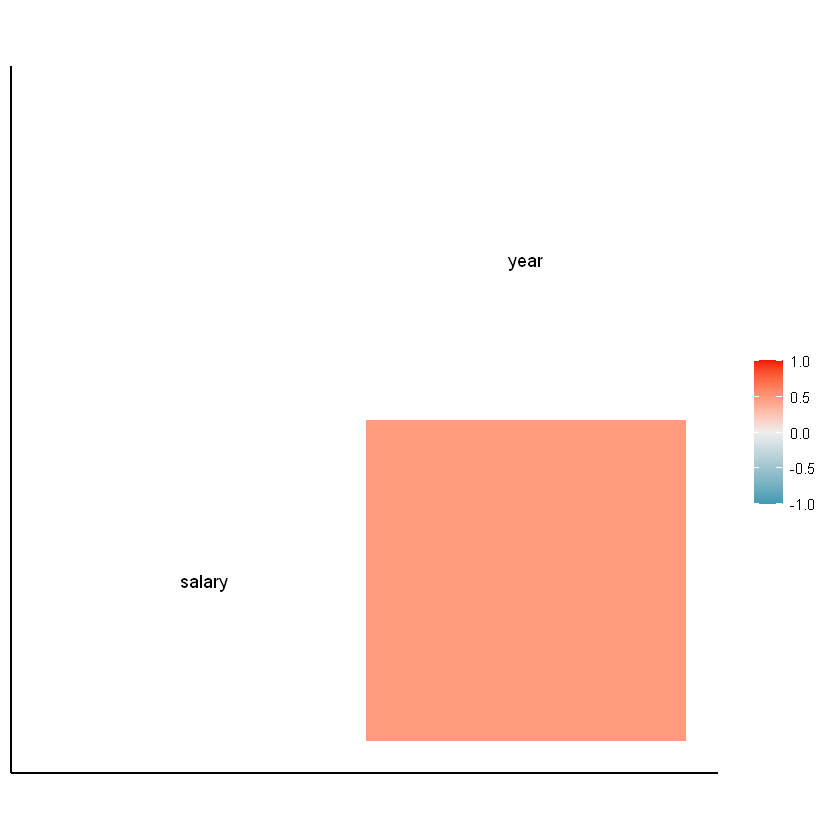

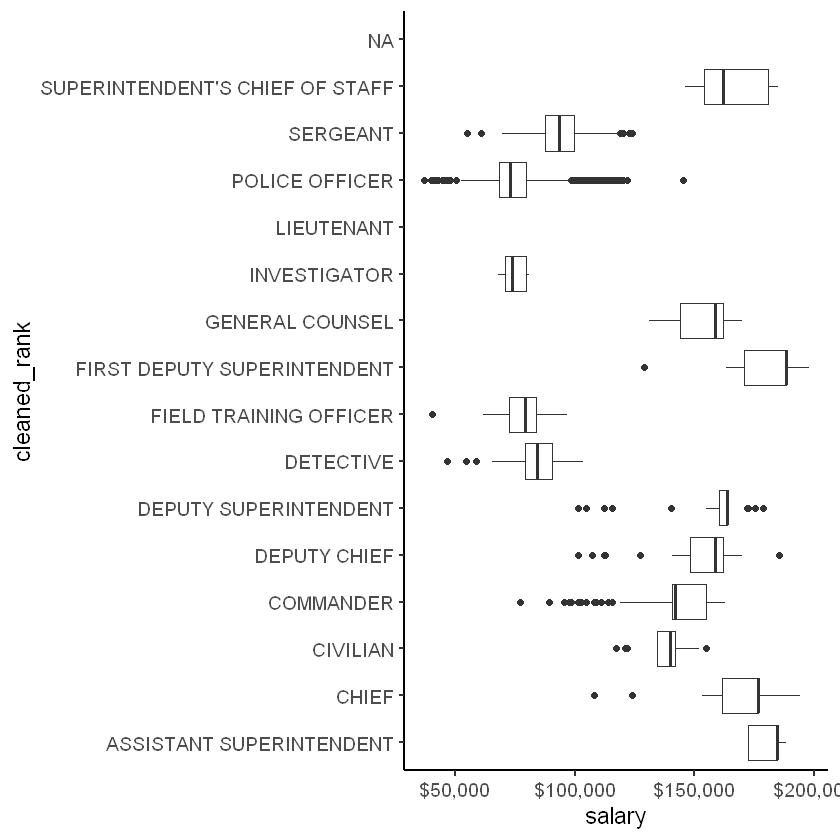

In [33]:
# Correlation Matrix
GGally::ggcorr(df_merged)

# Boxplot
ggplot(df_merged) + 
  aes(x = salary,
      y = cleaned_rank) +
  geom_boxplot() + 
  scale_x_continuous(labels = scales::label_dollar())

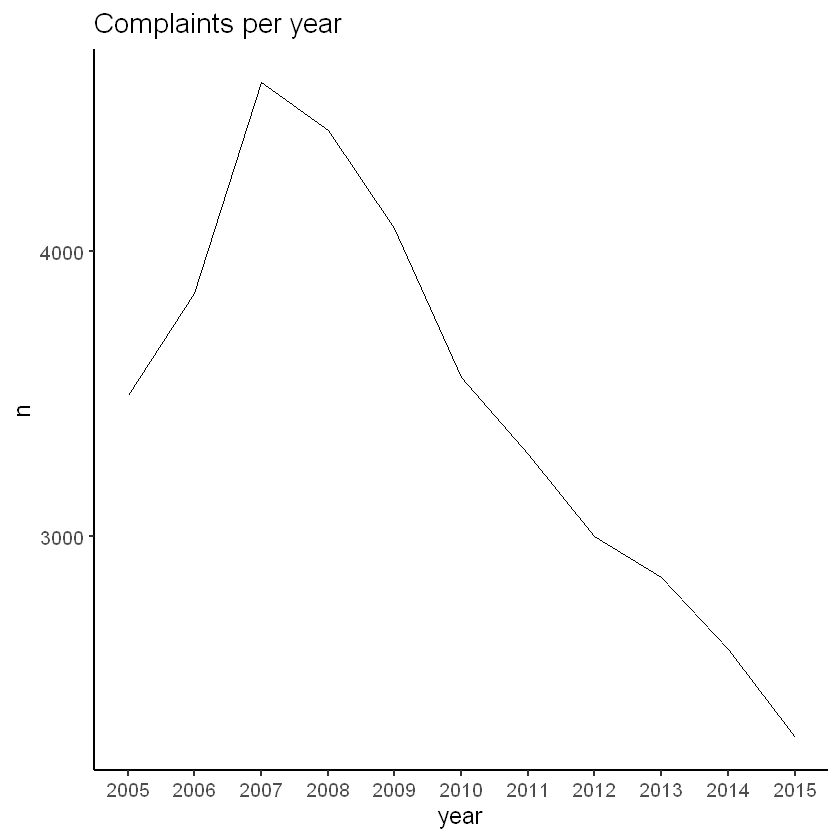

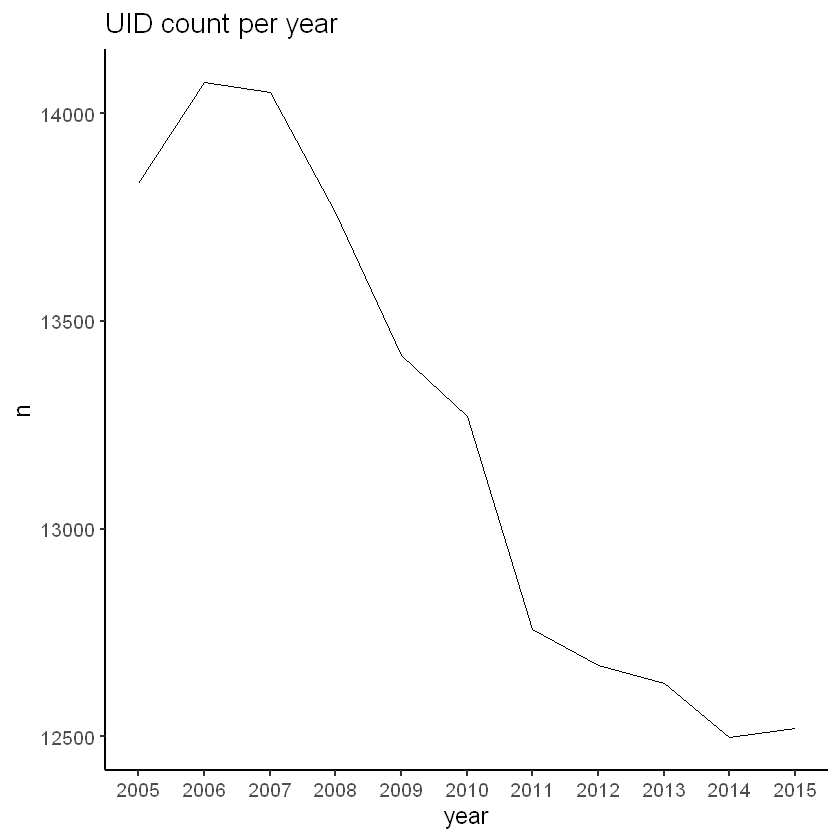

In [34]:
# Complaints by year
complaints_per_year <- df_merged %>% 
    group_by(year, cr_id) %>% 
    tally() %>% 
    drop_na() %>% 
    group_by(year) %>% 
    tally()

ggplot(complaints_per_year, aes(x = year, y = n)) + 
    geom_line() + 
    ggtitle("Complaints per year") + 
    scale_x_continuous(breaks = 2005:2015)

# Officer UID per year
off_per_year <- df_merged %>% 
    group_by(year, UID) %>% 
    tally() %>% 
    drop_na() %>% 
    group_by(year) %>% 
    tally()

ggplot(off_per_year, aes(x = year, y = n)) + 
    geom_line() + 
    ggtitle("UID count per year") + 
    scale_x_continuous(breaks = 2005:2015)

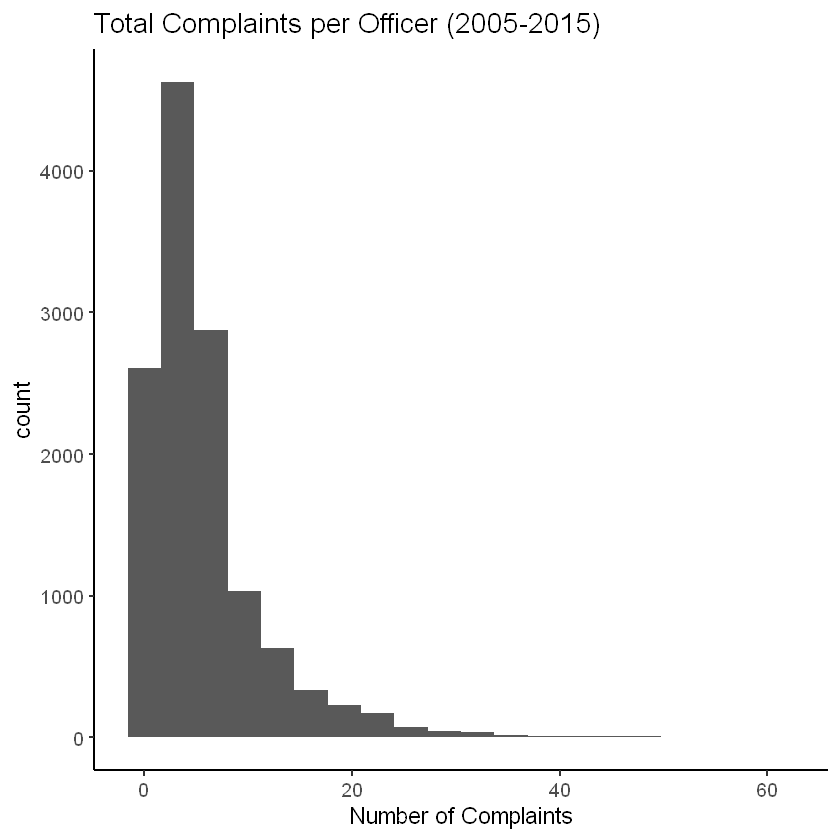

In [35]:
#Histogram of total complaints per officer - total complaints does not match because one complaint can be tied to multiple officers
complaints_per_off <- df_merged %>% 
    group_by(UID, cr_id) %>% 
    tally() %>% 
    drop_na() %>% 
    group_by(UID) %>% 
    tally()

ggplot(complaints_per_off, aes(x = n)) +
    labs(x = "Number of Complaints") + 
    ggtitle("Total Complaints per Officer (2005-2015)") +
    geom_histogram(bins = 20)

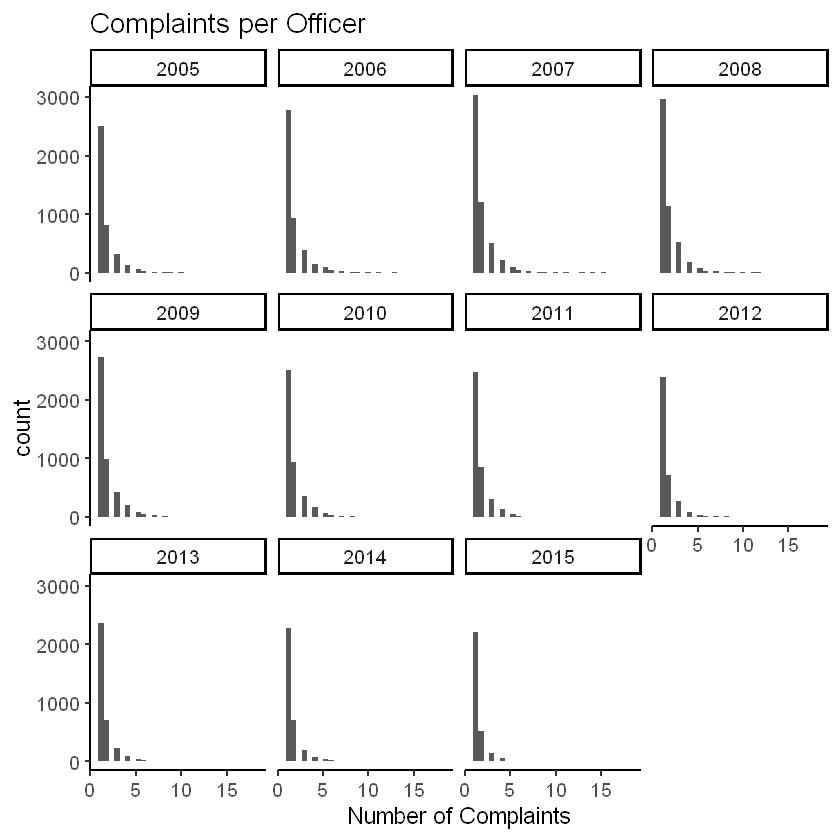

In [40]:
#Faceted per year histogram
complaints_per_off_yr <- df_merged %>% 
    group_by(UID, year, cr_id) %>% 
    tally() %>% 
    drop_na() %>% 
    group_by(UID, year) %>% 
    tally()

ggplot(complaints_per_off_yr, aes(x = n)) +
    labs(x = "Number of Complaints") + 
    ggtitle("Complaints per Officer") +
    geom_histogram(bins = 30) +
    facet_wrap(~year, nrow=3)